# Détection de départ avec un CNN

L'objectif de ce NoteBook est d'implémenter un réseau de neurones convolutif pour classifier dans des sons en deux catégories : "bips" et "non-bips". Ainsi en extrayant l'audio d'une vidéo de course de natation on puisse détecter l'instant de départ de la course. La méthode est la suivante : on travaille sur le spectrogramme de l'audio en le considérant comme une image, on place cette image en entrée d'un réseau CNN 2D et il nous renvoie la catégorie du son.

In [292]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from playsound import playsound

La fonction suivante permet de visualiser le spectrogramme d'un audio. On considère des audios de 0.5s.

In [199]:
def show_spectrogramme(audio_path):
    y, sr = librosa.load(audio_path, duration=0.49)
    ps = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    librosa.display.specshow(ps, y_axis='mel', x_axis='time')

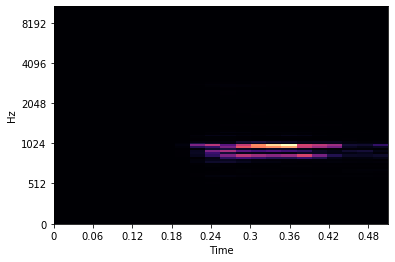

In [301]:
#Exemple de spectrogramme d'un bip
show_spectrogramme('bips/B0-8.wav')

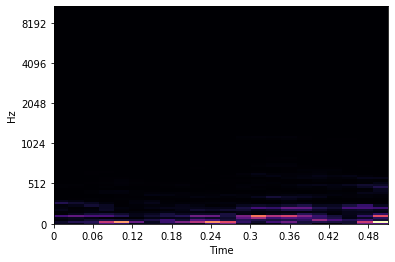

In [291]:
#Exemple de spectrogramme d'un non-bip
show_spectrogramme('non_bips/NB0-10.wav')

### Gestion de la data

Il faut un dossier 'bips' et un fichier 'non-bips' qui contienne respectivement des enregistrement de bips et de non bips. 

In [224]:
REBUILD_DATA = True
#Si le fichier 'training_data_bip.npy' n'existe pas encore :
# REBUILD_DATA = True  

if REBUILD_DATA:
    bipvsnonbip = BipVSNonBips()
    bipvsnonbip.make_training_data()

  3%|▎         | 3/116 [00:00<00:03, 28.36it/s]

bips


  4%|▎         | 4/113 [00:00<00:03, 35.04it/s]

non_bips


100%|██████████| 113/113 [00:03<00:00, 34.01it/s]


Nombre de bips du dataset = 116
Nombre de non-bips du dataset = 113


In [203]:
class BipVSNonBips():
    SIZE = 128
    BIPS = "bips"
    NON_BIPS = "non_bips"
    LABELS = {BIPS : 0, NON_BIPS : 1}
    training_data = []
    bipcount = 0
    non_bipcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label,f)
                y, sr = librosa.load(path, duration=0.49)
                ps = librosa.feature.melspectrogram(y=y, sr=sr)
                ps = cv2.resize(ps, (self.SIZE, self.SIZE))
                self.training_data.append([np.array(ps), np.eye(2)[self.LABELS[label]]])
            
                if label == self.BIPS:
                    self.bipcount += 1
            
                elif label == self.NON_BIPS:
                    self.non_bipcount += 1
                
        np.random.shuffle(self.training_data)
        np.save("training_data_bip.npy", self.training_data)
        print("Nombre de bips du dataset =",self.bipcount)
        print("Nombre de non-bips du dataset =",self.non_bipcount)

In [273]:
training_data = np.load("training_data_bip.npy", allow_pickle=True)
random.shuffle(training_data)

### Implémantation du réseau de neurones 

In [274]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, 5)
        self.conv2 = nn.Conv2d(24, 48, 5)        
        self.conv3 = nn.Conv2d(48, 48, 5)

        self.fc1 = nn.Linear(2400, 64)
        self.fc2 = nn.Linear(64, 2)        
        

    
    def forward(self,x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (4,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (4,2))
        x = F.relu(self.conv3(x))
        x = x.reshape(-1,2400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [275]:
net = Net()

In [276]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [277]:
#Convertion de la data en tensors
X = torch.Tensor([i[0] for i in training_data]).view(-1, 128, 128)
y = torch.Tensor([i[1] for i in training_data])

In [278]:
#Pourcentage de la data utilisée pour les tests, le reste du dataset est utilisé pour l'entrainement.
VAL_PCT = 0.3
val_size = int(len(X)*VAL_PCT)
 
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [279]:
#Batch Size et nombre d'epochs 
BATCH_SIZE = 20
EPOCHS = 1

In [280]:
#Entrainement du modèle

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,128,128)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
    print(loss)

100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

tensor(0.0698, grad_fn=<MseLossBackward>)


In [286]:
#Test du modèle
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,128,128))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct +=1
        elif predicted_class == 1:
            print("Erreur : non-bip détecté au lieu de bip")
        else:
            print("Erreur : bip détecté au lieu de non-bip")
        total +=1
        
print("Accuracy :", round(correct/total,3))

 60%|██████    | 41/68 [00:00<00:00, 124.69it/s]

Erreur : non-bip détecté au lieu de bip
Erreur : non-bip détecté au lieu de bip


100%|██████████| 68/68 [00:00<00:00, 134.25it/s]

Erreur : non-bip détecté au lieu de bip
Accuracy : 0.956


La fonction suivante permet de tester le réseau de neurones pour un exemple donné. Le réseau renvoie un tensor de dimension (1,2). La première valeur est la probabilité que le son en entrée soit un bip, et la deuxième valeur la probabilité que le son en entrée soit un non-bip.

In [282]:
def audio_classification(audio_path):
    y, sr = librosa.load(audio_path, duration=0.49)
    ps = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    ps = cv2.resize(ps, (128, 128))
    with torch.no_grad():
        net_out = net(torch.Tensor(ps).view(-1,1,128,128))
    return net_out

In [300]:
Path_test = 'Test/bip0.wav'

# Pour écouter le son, décommenter la ligne suivante
# playsound(Path_test)

out = audio_classification(Path_test)

if torch.argmax(out)==0 :
    print("Le son est un bip")
else :
    print("Le son n'est pas un bip")


Le son est un bip
